<a href="https://colab.research.google.com/github/denisecammarota/tesis-ib/blob/master/Fiteos/FitNormal_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pandas as pd

# Ejemplo 1: Modelo SIR Normal

In [32]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [33]:
def SIR_Model(t,beta,gamma):
  N = 1000
  # Initial number of infected and recovered individuals, I0 and R0.
  I0, R0 = 1, 0
  # Everyone else, S0, is susceptible to infection initially.
  S0 = N - I0 - R0
  #the rest that we had before
  y0 = S0,I0,R0
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T
  return I

In [34]:
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)
y_data = SIR_Model(t,beta,gamma) + np.random.normal(size=t.shape)

In [35]:
parameters, covariance = curve_fit(SIR_Model, t, y_data)

In [36]:
parameters

array([0.20005459, 0.10008143])

# Ejemplo 2: Intento de fittear el modelo normal neutro y con 10 provincias arbitrarias

In [37]:
def deriv_2(y0,t,beta,gamma,a):
  n = 10
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  for i in range(n):
    for j in range(n):
      A[i,j] = a
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [38]:
def SIR_Model_2(t,beta,gamma,a):
  n = 10
  S = np.ones(n)*10000.0
  R = np.zeros(n)*0.0
  I = np.zeros(n)*0.0
  I[0] = 100.0
  I[1] = 20.0
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_2,y0, t, args=(beta,gamma,a))
  I = result[:,n:2*n]
  return I

In [39]:
a = 0.001
I_data = SIR_Model_2(t,beta,gamma,a) 

In [40]:
print(I_data.shape)

(160, 10)


In [41]:
#parameters, covariance = curve_fit(SIR_Model_2, t, I_data,p0=[0.1,0.01,0.0001])

## aca probamos lmfit que es distinto a ver si funciona: funciona perfecto!!

In [42]:
def SIR_Model_2_lm(params,t,I_real):
  beta = params['beta']
  gamma = params['gamma']
  a = params['a']
  n = 10
  S = np.ones(n)*10000.0
  R = np.zeros(n)*0.0
  I = np.zeros(n)*0.0
  I[0] = 100.0
  I[1] = 20.0
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_2,y0, t, args=(beta,gamma,a))
  I_fake = result[:,n:2*n]
  return I_fake - I_real

In [43]:
pip install lmfit

In [44]:
from lmfit import Parameters,minimize, fit_report
params = Parameters()

In [45]:
params.add('beta', min=0.05, max=0.2)
params.add('gamma', min=0.05, max=0.2)
params.add('a',min=0.001,max=0.1)

In [46]:
fitted_params = minimize(SIR_Model_2_lm, params, args=(t,I_data,), method='least_squares')

In [47]:
beta = fitted_params.params['beta'].value
gamma = fitted_params.params['gamma'].value    
a = fitted_params.params['a'].value    

In [48]:
print(beta,gamma,a)

0.19999999770197888 0.09999999880697209 0.0010000000542441149


# Ejemplo 3: trato de fitear en serio los datos reales - modelo neutro

In [49]:
datos = pd.read_csv('series_temporales.csv',sep=",",header=None)

In [50]:
datos = datos.to_numpy()

In [51]:
datos = np.delete(datos,16,0)

In [52]:
datos.shape

(24, 297)

In [53]:
#vamos a cortar un poco algunos datos
datos = datos[:,:261]

In [54]:
def deriv_3(y0,t,beta,gamma,a):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  for i in range(n):
    for j in range(n):
      A[i,j] = a
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [55]:
def SIR_Model_3_lm(params,t,datos_reales):
  beta = params['beta']
  gamma = params['gamma']
  a = params['a']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_3,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit - datos_reales

In [56]:
def SIR_Model_3(beta,gamma,a,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_3,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit

In [57]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta', min=0.05, max=0.5)
params.add('gamma', min=0.05, max=0.5)
params.add('a',min=0.001,max=0.5)

In [58]:
fitted_params = minimize(SIR_Model_3_lm, params, args=(t,datos.T,), method='least_squares')

In [59]:
beta_fit = fitted_params.params['beta'].value
gamma_fit = fitted_params.params['gamma'].value    
a_fit = fitted_params.params['a'].value    

In [60]:
beta_fit/gamma_fit

1.175972060655716

In [61]:
fitted_params

In [62]:
resultado = SIR_Model_3(beta_fit,gamma_fit,a_fit,t)

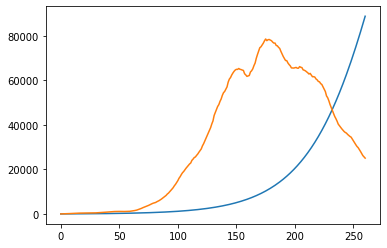

In [63]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])

In [64]:
beta_fit/gamma_fit

1.175972060655716

# Ejemplo 4: trato de fitear en serio los datos reales - modelo distancias solas

In [65]:
orden_falso = ['CABA','CB','COR','FO','BA','LR','MZ','NQ','ER','MI','CHU','CHA','SC','CA','TU','ST','SJ','SL','JU','SF','LP','SDE','TF','RN']
orden_provs = ['BA','CABA','CA','CHA','CHU','COR','CB','ER','FO','JU','LP','LR','MZ','MI','NQ','RN','ST','SJ','SL','SC','SF','SDE','TF','TU']
distancia = np.zeros((24,24))
distancia[0,:] = np.array([1,715,940,1191,61,1150,1050,1158,480,1040,1455,1023,2635,1155,1203,1510,1110,790,1543,478,620,1043,3228,960])
distancia[1,1:] = np.array([1,898,1043,757,435,670,1137,361,1213,1455,875,3635,440,590,897,500,420,930,330,600,430,3228,1194])
distancia[2,2:] = np.array([1,191,978,993,1565,1989,590,315,2187,23,3367,845,791,803,1398,1318,883,568,1378,633,3960,2046])
distancia[3,3:] = np.array([1,1253,1136,1710,2060,744,506,2378,168,3558,988,936,948,1543,1463,960,713,1523,776,4151,2117])
distancia[4,4:] = np.array([1,1189,1152,1197,555,1061,1414,996,2551,1188,1309,1614,1213,894,1645,527,670,1184,3132,957])
distancia[5,5:] = np.array([1,617,1472,796,1308,1890,970,3070,156,388,695,450,550,770,765,1035,360,3663,1629])
distancia[6,6:] = np.array([1,855,916,1925,1620,1587,2800,773,1005,1227,167,260,1345,885,765,977,3393,1359])
distancia[7,7:] = np.array([1,1378,2198,750,2012,1930,1588,1860,2082,1022,883,2200,1347,537,1567,2523,660])
distancia[8,8:] = np.array([1,820,1696,576,2876,801,798,1105,861,656,1138,31,841,1638,3469,1435])
distancia[9,9:] = np.array([1,2495,338,3675,1160,1106,1118,1758,1633,1198,883,1660,948,4268,2000])
distancia[10,10:] = np.array([1,2210,1180,1895,2045,2352,1680,1360,2385,1665,855,1885,1773,495])
distancia[11,11:] = np.array([1,3390,822,765,780,1420,1295,860,545,1475,610,3983,2069])
distancia[12,12:] = np.array([1,3075,3225,3532,2860,2540,3565,2845,2035,3065,593,1675])
distancia[13,13:] = np.array([1,232,539,606,705,572,770,1040,212,3668,1634])
distancia[14,14:] = np.array([1,307,838,938,340,767,1190,160,3818,1784])
distancia[15,15:] = np.array([1,1145,1245,99,1074,1497,467,4125,2091])
distancia[16,16:] = np.array([1,320,1220,830,825,810,3435,1419])
distancia[17,17:] = np.array([1,1320,625,505,850,3133,1099])
distancia[18,18:] = np.array([1,1107,1530,500,4158,2124])
distancia[19,19:] = np.array([1,810,607,3438,1404])
distancia[20,20:] = np.array([1,1030,2628,594])
distancia[21,21:] = np.array([1,3658,1624])
distancia[22,22:] = np.array([1,2268])
distancia[23,23:] = np.array([1])

In [66]:
distancia_falsa = distancia + distancia.T

In [67]:
np.fill_diagonal(distancia_falsa,1)

In [68]:
distancia_falsa

array([[1.000e+00, 7.150e+02, 9.400e+02, 1.191e+03, 6.100e+01, 1.150e+03,
        1.050e+03, 1.158e+03, 4.800e+02, 1.040e+03, 1.455e+03, 1.023e+03,
        2.635e+03, 1.155e+03, 1.203e+03, 1.510e+03, 1.110e+03, 7.900e+02,
        1.543e+03, 4.780e+02, 6.200e+02, 1.043e+03, 3.228e+03, 9.600e+02],
       [7.150e+02, 1.000e+00, 8.980e+02, 1.043e+03, 7.570e+02, 4.350e+02,
        6.700e+02, 1.137e+03, 3.610e+02, 1.213e+03, 1.455e+03, 8.750e+02,
        3.635e+03, 4.400e+02, 5.900e+02, 8.970e+02, 5.000e+02, 4.200e+02,
        9.300e+02, 3.300e+02, 6.000e+02, 4.300e+02, 3.228e+03, 1.194e+03],
       [9.400e+02, 8.980e+02, 1.000e+00, 1.910e+02, 9.780e+02, 9.930e+02,
        1.565e+03, 1.989e+03, 5.900e+02, 3.150e+02, 2.187e+03, 2.300e+01,
        3.367e+03, 8.450e+02, 7.910e+02, 8.030e+02, 1.398e+03, 1.318e+03,
        8.830e+02, 5.680e+02, 1.378e+03, 6.330e+02, 3.960e+03, 2.046e+03],
       [1.191e+03, 1.043e+03, 1.910e+02, 1.000e+00, 1.253e+03, 1.136e+03,
        1.710e+03, 2.060e+03, 7.440

In [69]:
#reacomodamos las matrices de distancias y distancias reales
#tenemos orden_provs y orden_falsos
distancia_real = np.zeros((24,24))
for i in range(24):
  n_p1 = orden_provs[i]
  for j in range(24):
    n_p2 = orden_provs[j]
    n_p1_lista2 = orden_falso.index(n_p1)
    n_p2_lista2 = orden_falso.index(n_p2)
    distancia_real[i,j] = distancia_falsa[n_p1_lista2,n_p2_lista2]

In [70]:
def deriv_4(y0,t,beta,gamma,a):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  for i in range(n):
    for j in range(n):
      A[i,j] = a*(1/distancia_real[i,j])
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [71]:
def SIR_Model_4_lm(params,t,datos_reales):
  beta = params['beta']
  gamma = params['gamma']
  a = params['a']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_4,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return (I_fit - datos_reales)**2

In [72]:
def SIR_Model_4(beta,gamma,a,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_4,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit

In [73]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta', min=0.05, max=0.5)
params.add('gamma', min=0.05, max=0.5)
params.add('a',min=0.001,max=0.5)

In [74]:
fitted_params = minimize(SIR_Model_4_lm, params, args=(t,datos.T,), method='least_squares')

In [75]:
beta_fit = fitted_params.params['beta'].value
gamma_fit = fitted_params.params['gamma'].value    
a_fit = fitted_params.params['a'].value    

In [76]:
beta_fit/gamma_fit

1.1170895887646368

In [77]:
fitted_params

In [78]:
resultado = SIR_Model_4(beta_fit,gamma_fit,a_fit,t)

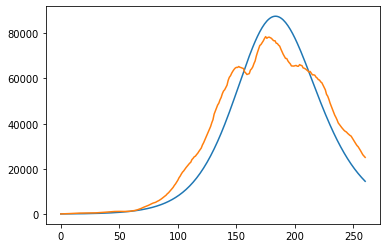

In [79]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])

# Ejemplo 5: trato de fitear en serio los datos reales - modelo poblaciones solas

In [80]:
population = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
nt = np.sum(population)

In [81]:
def deriv_5(y0,t,beta,gamma,a):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  for i in range(n):
    for j in range(n):
      A[i,j] = a*((population[i]+population[j])/nt)
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [82]:
def SIR_Model_5_lm(params,t,datos_reales):
  beta = params['beta']
  gamma = params['gamma']
  a = params['a']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_5,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit - datos_reales

In [83]:
def SIR_Model_5(beta,gamma,a,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_5,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit

In [84]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta', min=0.05, max=0.5)
params.add('gamma', min=0.05, max=0.5)
params.add('a',min=0.00001,max=0.5)

In [85]:
fitted_params = minimize(SIR_Model_5_lm, params, args=(t,datos.T,), method='least_squares')

In [86]:
beta_fit = fitted_params.params['beta'].value
gamma_fit = fitted_params.params['gamma'].value    
a_fit = fitted_params.params['a'].value    

In [87]:
beta_fit/gamma_fit

1.1165302751276782

In [88]:
fitted_params

In [89]:
resultado = SIR_Model_5(beta_fit,gamma_fit,a_fit,t)

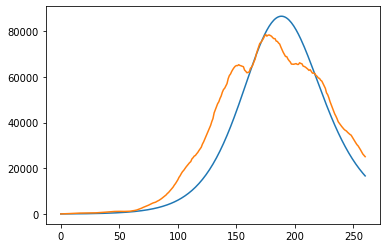

In [90]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])

# Ejemplo 6: trato de fitear en serio los datos reales - modelo poblaciones y distancias

In [91]:
def deriv_6(y0,t,beta,gamma,a):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  for i in range(n):
    for j in range(n):
      A[i,j] = a*((population[i]+population[j])/nt)*(1/distancia_real[i,j])
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [92]:
def SIR_Model_6_lm(params,t,datos_reales):
  beta = params['beta']
  gamma = params['gamma']
  a = params['a']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_6,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit - datos_reales

In [93]:
def SIR_Model_6(beta,gamma,a,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_6,y0, t, args=(beta,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit

In [94]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta', min=0.05, max=0.5)
params.add('gamma', min=0.05, max=0.5)
params.add('a',min=0.001,max=1)

In [95]:
fitted_params = minimize(SIR_Model_6_lm, params, args=(t,datos.T,), method='least_squares')

In [96]:
beta_fit = fitted_params.params['beta'].value
gamma_fit = fitted_params.params['gamma'].value    
a_fit = fitted_params.params['a'].value    

In [97]:
beta_fit/gamma_fit

1.1162141452360244

In [98]:
fitted_params

In [99]:
resultado = SIR_Model_5(beta_fit,gamma_fit,a_fit,t)

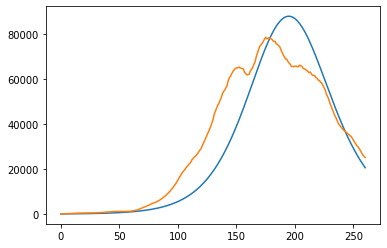

In [100]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])

In [101]:
1/gamma_fit

2.6432767762433294

# Ejemplo 7: Control sin matrices de conectividad 

In [102]:
def deriv_7(y0,t,beta,gamma):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  N = X+Y+Z
  dXdt = -beta*X*Y/N 
  dYdt = beta*X*Y/N - gamma*Y 
  dZdt = gamma*Y 
  return np.concatenate((dXdt,dYdt,dZdt))

In [103]:
def SIR_Model_7_lm(params,t,datos_reales):
  beta = params['beta']
  gamma = params['gamma']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_7,y0, t, args=(beta,gamma))
  I_fit = result[:,n:2*n]
  return I_fit - datos_reales

In [104]:
def SIR_Model_7(beta,gamma,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_7,y0, t, args=(beta,gamma))
  I_fit = result[:,n:2*n]
  return I_fit

In [105]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta', min=0.05, max=0.5)
params.add('gamma', min=0.05, max=0.5)

In [106]:
fitted_params = minimize(SIR_Model_7_lm, params, args=(t,datos.T,), method='least_squares')

In [107]:
beta_fit = fitted_params.params['beta'].value
gamma_fit = fitted_params.params['gamma'].value    

In [108]:
beta_fit/gamma_fit

1.1166243661774755

In [109]:
fitted_params

In [110]:
resultado = SIR_Model_7(beta_fit,gamma_fit,t)

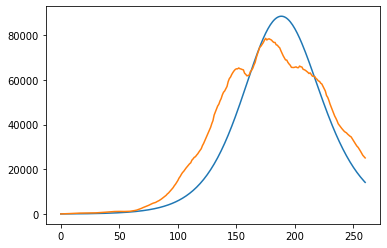

In [111]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])

In [112]:
1/gamma_fit

2.512146577747284

# A partir de aca, es cambiando los beta por beta_i

## Ejemplo 3.2: modelo neutral - diferentes beta_i

In [133]:
def deriv_3_2(y0,t,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  beta = np.array([beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24])
  for i in range(n):
    for j in range(n):
      A[i,j] = a
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [134]:
def SIR_Model_3_lm_2(params,t,datos_reales):
  beta_1= params['beta_1']
  beta_2= params['beta_2']
  beta_3= params['beta_3']
  beta_4= params['beta_4']
  beta_5= params['beta_5']
  beta_6= params['beta_6']
  beta_7= params['beta_7']
  beta_8= params['beta_8']
  beta_9= params['beta_9']
  beta_10= params['beta_10']
  beta_11= params['beta_11']
  beta_12= params['beta_12']
  beta_13= params['beta_13']
  beta_14= params['beta_14']
  beta_15= params['beta_15']
  beta_16= params['beta_16']
  beta_17= params['beta_17']
  beta_18= params['beta_18']
  beta_19= params['beta_19']
  beta_20= params['beta_20']
  beta_21= params['beta_21']
  beta_22= params['beta_22']
  beta_23= params['beta_23']
  beta_24= params['beta_24']
  gamma = params['gamma']
  a = params['a']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_3_2,y0, t, args=(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit - datos_reales

In [135]:
def SIR_Model_3_2(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_3_2,y0, t, args=(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit

In [143]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta_1', min=0.0, max=0.5)
params.add('beta_2', min=0.0, max=0.5)
params.add('beta_3', min=0.0, max=0.5)
params.add('beta_4', min=0.0, max=0.5)
params.add('beta_5', min=0.0, max=0.5)
params.add('beta_6', min=0.0, max=0.5)
params.add('beta_7', min=0.0, max=0.5)
params.add('beta_8', min=0.0, max=0.5)
params.add('beta_9', min=0.0, max=0.5)
params.add('beta_10', min=0.0, max=0.5)
params.add('beta_11', min=0.0, max=0.5)
params.add('beta_12', min=0.0, max=0.5)
params.add('beta_13', min=0.0, max=0.5)
params.add('beta_14', min=0.0, max=0.5)
params.add('beta_15', min=0.0, max=0.5)
params.add('beta_16', min=0.0, max=0.5)
params.add('beta_17', min=0.0, max=0.5)
params.add('beta_18', min=0.0, max=0.5)
params.add('beta_19', min=0.0, max=0.5)
params.add('beta_20', min=0.0, max=0.5)
params.add('beta_21', min=0.0, max=0.5)
params.add('beta_22', min=0.0, max=0.5)
params.add('beta_23', min=0.0, max=0.5)
params.add('beta_24', min=0.0, max=0.5)
params.add('gamma', min=0.05, max=0.5)
params.add('a',min=0.001,max=0.5)

In [144]:
fitted_params = minimize(SIR_Model_3_lm_2, params, args=(t,datos.T,), method='least_squares')

In [145]:
beta_1_fit = fitted_params.params['beta_1'].value
beta_2_fit = fitted_params.params['beta_2'].value
beta_3_fit = fitted_params.params['beta_3'].value
beta_4_fit = fitted_params.params['beta_4'].value
beta_5_fit = fitted_params.params['beta_5'].value
beta_6_fit = fitted_params.params['beta_6'].value
beta_7_fit = fitted_params.params['beta_7'].value
beta_8_fit = fitted_params.params['beta_8'].value
beta_9_fit = fitted_params.params['beta_9'].value
beta_10_fit = fitted_params.params['beta_10'].value
beta_11_fit = fitted_params.params['beta_11'].value
beta_12_fit = fitted_params.params['beta_12'].value
beta_13_fit = fitted_params.params['beta_13'].value
beta_14_fit = fitted_params.params['beta_14'].value
beta_15_fit = fitted_params.params['beta_15'].value
beta_16_fit = fitted_params.params['beta_16'].value
beta_17_fit = fitted_params.params['beta_17'].value
beta_18_fit = fitted_params.params['beta_18'].value
beta_19_fit = fitted_params.params['beta_19'].value
beta_20_fit = fitted_params.params['beta_20'].value
beta_21_fit = fitted_params.params['beta_21'].value
beta_22_fit = fitted_params.params['beta_22'].value
beta_23_fit = fitted_params.params['beta_23'].value
beta_24_fit = fitted_params.params['beta_24'].value
gamma_fit = fitted_params.params['gamma'].value    
a_fit = fitted_params.params['a'].value    

In [146]:
1/gamma_fit

3.782440488672041

In [147]:
fitted_params

In [148]:
resultado = SIR_Model_3_2(beta_1_fit,beta_2_fit,beta_3_fit,beta_4_fit,beta_5_fit,beta_6_fit,beta_7_fit,beta_8_fit,beta_9_fit,beta_10_fit,beta_11_fit,beta_12_fit,beta_13_fit,beta_14_fit,beta_15_fit,beta_16_fit,beta_17_fit,beta_18_fit,beta_19_fit,beta_20_fit,beta_21_fit,beta_22_fit,beta_23_fit,beta_24_fit,gamma_fit,a_fit,t)

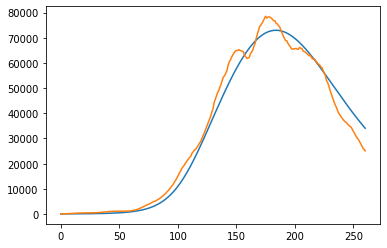

In [149]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])

## Ejemplo 4.2: distancias solas - diferentes beta_i

In [123]:
def deriv_4_2(y0,t,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  beta = np.array([beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24])
  for i in range(n):
    for j in range(n):
      A[i,j] =  a*(1/distancia_real[i,j])
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [124]:
def SIR_Model_4_lm_2(params,t,datos_reales):
  beta_1= params['beta_1']
  beta_2= params['beta_2']
  beta_3= params['beta_3']
  beta_4= params['beta_4']
  beta_5= params['beta_5']
  beta_6= params['beta_6']
  beta_7= params['beta_7']
  beta_8= params['beta_8']
  beta_9= params['beta_9']
  beta_10= params['beta_10']
  beta_11= params['beta_11']
  beta_12= params['beta_12']
  beta_13= params['beta_13']
  beta_14= params['beta_14']
  beta_15= params['beta_15']
  beta_16= params['beta_16']
  beta_17= params['beta_17']
  beta_18= params['beta_18']
  beta_19= params['beta_19']
  beta_20= params['beta_20']
  beta_21= params['beta_21']
  beta_22= params['beta_22']
  beta_23= params['beta_23']
  beta_24= params['beta_24']
  gamma = params['gamma']
  a = params['a']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_4_2,y0, t, args=(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit - datos_reales

In [125]:
def SIR_Model_4_2(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_4_2,y0, t, args=(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit

In [150]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta_1', min=0.0, max=0.5)
params.add('beta_2', min=0.0, max=0.5)
params.add('beta_3', min=0.0, max=0.5)
params.add('beta_4', min=0.0, max=0.5)
params.add('beta_5', min=0.0, max=0.5)
params.add('beta_6', min=0.0, max=0.5)
params.add('beta_7', min=0.0, max=0.5)
params.add('beta_8', min=0.0, max=0.5)
params.add('beta_9', min=0.0, max=0.5)
params.add('beta_10', min=0.0, max=0.5)
params.add('beta_11', min=0.0, max=0.5)
params.add('beta_12', min=0.0, max=0.5)
params.add('beta_13', min=0.0, max=0.5)
params.add('beta_14', min=0.0, max=0.5)
params.add('beta_15', min=0.0, max=0.5)
params.add('beta_16', min=0.0, max=0.5)
params.add('beta_17', min=0.0, max=0.5)
params.add('beta_18', min=0.0, max=0.5)
params.add('beta_19', min=0.0, max=0.5)
params.add('beta_20', min=0.0, max=0.5)
params.add('beta_21', min=0.0, max=0.5)
params.add('beta_22', min=0.0, max=0.5)
params.add('beta_23', min=0.0, max=0.5)
params.add('beta_24', min=0.0, max=0.5)
params.add('gamma', min=0.05, max=0.5)
params.add('a',min=0.001,max=0.5)

In [151]:
fitted_params = minimize(SIR_Model_4_lm_2, params, args=(t,datos.T,), method='least_squares')

In [152]:
beta_1_fit = fitted_params.params['beta_1'].value
beta_2_fit = fitted_params.params['beta_2'].value
beta_3_fit = fitted_params.params['beta_3'].value
beta_4_fit = fitted_params.params['beta_4'].value
beta_5_fit = fitted_params.params['beta_5'].value
beta_6_fit = fitted_params.params['beta_6'].value
beta_7_fit = fitted_params.params['beta_7'].value
beta_8_fit = fitted_params.params['beta_8'].value
beta_9_fit = fitted_params.params['beta_9'].value
beta_10_fit = fitted_params.params['beta_10'].value
beta_11_fit = fitted_params.params['beta_11'].value
beta_12_fit = fitted_params.params['beta_12'].value
beta_13_fit = fitted_params.params['beta_13'].value
beta_14_fit = fitted_params.params['beta_14'].value
beta_15_fit = fitted_params.params['beta_15'].value
beta_16_fit = fitted_params.params['beta_16'].value
beta_17_fit = fitted_params.params['beta_17'].value
beta_18_fit = fitted_params.params['beta_18'].value
beta_19_fit = fitted_params.params['beta_19'].value
beta_20_fit = fitted_params.params['beta_20'].value
beta_21_fit = fitted_params.params['beta_21'].value
beta_22_fit = fitted_params.params['beta_22'].value
beta_23_fit = fitted_params.params['beta_23'].value
beta_24_fit = fitted_params.params['beta_24'].value
gamma_fit = fitted_params.params['gamma'].value    
a_fit = fitted_params.params['a'].value    

In [153]:
1/gamma_fit

2.749371756541313

In [154]:
fitted_params

In [155]:
resultado = SIR_Model_4_2(beta_1_fit,beta_2_fit,beta_3_fit,beta_4_fit,beta_5_fit,beta_6_fit,beta_7_fit,beta_8_fit,beta_9_fit,beta_10_fit,beta_11_fit,beta_12_fit,beta_13_fit,beta_14_fit,beta_15_fit,beta_16_fit,beta_17_fit,beta_18_fit,beta_19_fit,beta_20_fit,beta_21_fit,beta_22_fit,beta_23_fit,beta_24_fit,gamma_fit,a_fit,t)

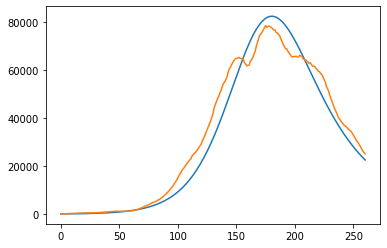

In [156]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])

## Ejemplo 5.2: distancias solas - diferentes poblaciones

In [157]:
def deriv_5_2(y0,t,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a):
  n = 24
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  A = np.zeros(shape=(n,n))
  beta = np.array([beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24])
  for i in range(n):
    for j in range(n):
      A[i,j] =  a*((population[i]+population[j])/nt)
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if i != j:
        A[i,i] -= A[i,j]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [158]:
def SIR_Model_5_lm_2(params,t,datos_reales):
  beta_1= params['beta_1']
  beta_2= params['beta_2']
  beta_3= params['beta_3']
  beta_4= params['beta_4']
  beta_5= params['beta_5']
  beta_6= params['beta_6']
  beta_7= params['beta_7']
  beta_8= params['beta_8']
  beta_9= params['beta_9']
  beta_10= params['beta_10']
  beta_11= params['beta_11']
  beta_12= params['beta_12']
  beta_13= params['beta_13']
  beta_14= params['beta_14']
  beta_15= params['beta_15']
  beta_16= params['beta_16']
  beta_17= params['beta_17']
  beta_18= params['beta_18']
  beta_19= params['beta_19']
  beta_20= params['beta_20']
  beta_21= params['beta_21']
  beta_22= params['beta_22']
  beta_23= params['beta_23']
  beta_24= params['beta_24']
  gamma = params['gamma']
  a = params['a']
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_5_2,y0, t, args=(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit - datos_reales

In [159]:
def SIR_Model_5_2(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a,t):
  n = 24
  S = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
  R = np.zeros(n)*0.0
  I = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces
  y0 = np.concatenate((S,I,R))
  result = odeint(deriv_5_2,y0, t, args=(beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,gamma,a))
  I_fit = result[:,n:2*n]
  return I_fit

In [160]:
t = np.arange(datos.shape[1])
params = Parameters()
params.add('beta_1', min=0.0, max=0.5)
params.add('beta_2', min=0.0, max=0.5)
params.add('beta_3', min=0.0, max=0.5)
params.add('beta_4', min=0.0, max=0.5)
params.add('beta_5', min=0.0, max=0.5)
params.add('beta_6', min=0.0, max=0.5)
params.add('beta_7', min=0.0, max=0.5)
params.add('beta_8', min=0.0, max=0.5)
params.add('beta_9', min=0.0, max=0.5)
params.add('beta_10', min=0.0, max=0.5)
params.add('beta_11', min=0.0, max=0.5)
params.add('beta_12', min=0.0, max=0.5)
params.add('beta_13', min=0.0, max=0.5)
params.add('beta_14', min=0.0, max=0.5)
params.add('beta_15', min=0.0, max=0.5)
params.add('beta_16', min=0.0, max=0.5)
params.add('beta_17', min=0.0, max=0.5)
params.add('beta_18', min=0.0, max=0.5)
params.add('beta_19', min=0.0, max=0.5)
params.add('beta_20', min=0.0, max=0.5)
params.add('beta_21', min=0.0, max=0.5)
params.add('beta_22', min=0.0, max=0.5)
params.add('beta_23', min=0.0, max=0.5)
params.add('beta_24', min=0.0, max=0.5)
params.add('gamma', min=0.05, max=0.5)
params.add('a',min=0.001,max=0.5)

In [161]:
fitted_params = minimize(SIR_Model_5_lm_2, params, args=(t,datos.T,), method='least_squares')

In [162]:
beta_1_fit = fitted_params.params['beta_1'].value
beta_2_fit = fitted_params.params['beta_2'].value
beta_3_fit = fitted_params.params['beta_3'].value
beta_4_fit = fitted_params.params['beta_4'].value
beta_5_fit = fitted_params.params['beta_5'].value
beta_6_fit = fitted_params.params['beta_6'].value
beta_7_fit = fitted_params.params['beta_7'].value
beta_8_fit = fitted_params.params['beta_8'].value
beta_9_fit = fitted_params.params['beta_9'].value
beta_10_fit = fitted_params.params['beta_10'].value
beta_11_fit = fitted_params.params['beta_11'].value
beta_12_fit = fitted_params.params['beta_12'].value
beta_13_fit = fitted_params.params['beta_13'].value
beta_14_fit = fitted_params.params['beta_14'].value
beta_15_fit = fitted_params.params['beta_15'].value
beta_16_fit = fitted_params.params['beta_16'].value
beta_17_fit = fitted_params.params['beta_17'].value
beta_18_fit = fitted_params.params['beta_18'].value
beta_19_fit = fitted_params.params['beta_19'].value
beta_20_fit = fitted_params.params['beta_20'].value
beta_21_fit = fitted_params.params['beta_21'].value
beta_22_fit = fitted_params.params['beta_22'].value
beta_23_fit = fitted_params.params['beta_23'].value
beta_24_fit = fitted_params.params['beta_24'].value
gamma_fit = fitted_params.params['gamma'].value    
a_fit = fitted_params.params['a'].value    

In [163]:
1/gamma_fit

7.223140644529846

In [164]:
fitted_params

In [165]:
resultado = SIR_Model_5_2(beta_1_fit,beta_2_fit,beta_3_fit,beta_4_fit,beta_5_fit,beta_6_fit,beta_7_fit,beta_8_fit,beta_9_fit,beta_10_fit,beta_11_fit,beta_12_fit,beta_13_fit,beta_14_fit,beta_15_fit,beta_16_fit,beta_17_fit,beta_18_fit,beta_19_fit,beta_20_fit,beta_21_fit,beta_22_fit,beta_23_fit,beta_24_fit,gamma_fit,a_fit,t)

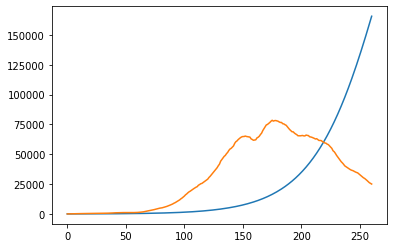

In [172]:
plt.plot(resultado[:,0])
plt.plot(datos.T[:,0])